<a href="https://colab.research.google.com/github/Rique3012/TransCal2/blob/main/Cilindro_Transferencia_Calor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regime Permanente

(200, 200)


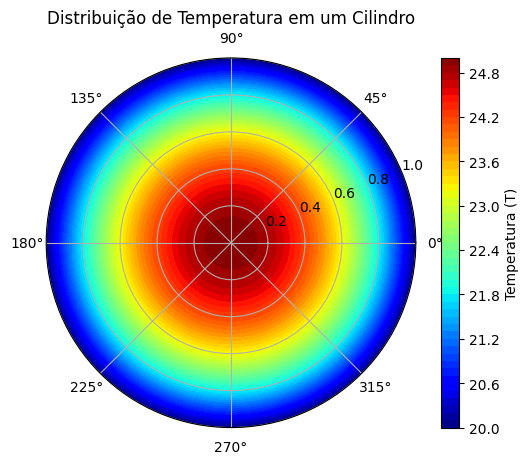

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Configurações da simulação
T0 = 20    # Temperatura inicial
S = 10     # Taxa de geração interna de calor
R = 1      # Raio do fio
K = 0.5    # Coeficiente de condução térmica
num_points = 200  # Número de pontos no diâmetro do fio

# Função para calcular a temperatura
def calculate_temperature(r, T0, S, R, K):
    return T0 + (S * R**2 / (4 * K)) * (1 - (r / R)**2)

# Gerar dados
theta = np.linspace(0, 2 * np.pi, num_points)
r = np.linspace(0, R, num_points)
T = calculate_temperature(r, T0, S, R, K)

# Criar um grid polar
r, theta = np.meshgrid(r, theta)

# Convertendo para coordenadas cartesianas
X = r * np.cos(theta)
Y = r * np.sin(theta)

# Mapeando as temperaturas para o grid
T_grid = calculate_temperature(r, T0, S, R, K)
print(np.shape(T_grid))

# Configurar o plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
c = ax.contourf(theta, r, T_grid, 50, cmap=cm.jet)
fig.colorbar(c, ax=ax, label='Temperatura (T)')
ax.set_title('Distribuição de Temperatura em um Cilindro')
plt.show()


# Regime Transiente

//TR Fixo

(200, 200, 10000)


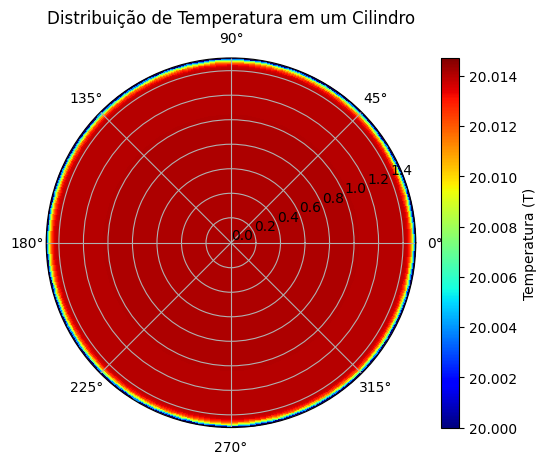

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm

# Configurações da simulação
T0 = 20                             # Temperatura inicial
S = 1000                            # Taxa de geração interna de calor
R = 1.5                            # Raio do fio
K = 0.5 * 100                       # Coeficiente de condução térmica do fio
KI = 0.05                           # Coeficiente de condução térmica do isolante
alfa = 4
alfaI = 0.04                             # Difusividade térmica
#alfaI = 0.1492                      # Difusividade térmica do isolante
num_points = 200                    # Número de pontos no diâmetro do fio
dr = R / (num_points)               # Passo de raio
dt = 0.5 * (dr**2) /(4 * alfa)      # Passo de tempo
beta = alfa * dt / (dr**2)          # Parâmetro beta
betaI = alfaI * dt / (dr**2)        # Parâmetro beta do isolante
tempo = 10000 * dt
nsteps = int(tempo / dt)

# Inicialização do array de temperatura
u = T0 * np.ones(num_points)

# Gerar dados
theta = np.linspace(0, 2 * np.pi, num_points)
r = np.linspace(0, R, num_points)

# Criar um grid polar
r, theta = np.meshgrid(r, theta)

# Cria um tensor de shape = (num_points,num_points,nsteps) para armazenar
# todas as informações da simulação
T = np.tile(u,(num_points,1))
T_tensor =T.copy().reshape((num_points,num_points,1))

tempo_array = np.linspace(0, tempo, nsteps-1)
tempo_tensor = tempo_array.copy().reshape((1,1,nsteps-1))

tempo_tensor_broadcasted = np.broadcast_to(tempo_tensor, (T_tensor.shape[0], T_tensor.shape[1], tempo_tensor.shape[2]))

mapa_temporal = np.concatenate((T_tensor, tempo_tensor_broadcasted), axis=-1)
print(mapa_temporal.shape)

# Simulação
raio = 0
for k in range(len(tempo_array)):
  u0 = u.copy()

  u[0] = (1 - 4*beta) * u0[0] + 4*beta * u0[1] + (alfa * dt)/K * S

  for i in range(1, num_points - 1):
    if raio <= 1:
      u[i] = (beta - beta/(2*i)) * u0[i-1] + (1 - 2*beta) * u0[i] + (beta + beta/(2*i)) * u0[i+1] + (alfa * dt)/K * S
    else:
      u[i] = (betaI - betaI/(2*i)) * u0[i-1] + (1 - 2*betaI) * u0[i] + (betaI + betaI/(2*i)) * u0[i+1] + (alfaI * dt)/KI

    raio += dr

    #T = np.tile(u,(num_points,1))
    mapa_temporal[:, :, k] = np.tile(u, (num_points, 1))
    #mapa_temporal[i,:,k] = u[i]

  #print(f"Temperatura média: {np.average(u)}ºC")

# Seleciona os frames a serem animados
movie_frames = mapa_temporal[:,:,0::50]   #200 frames animados

# Visualização
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
pcm = ax.pcolormesh(theta,r, movie_frames[:,:,0], cmap ='jet', vmin = T0, vmax = np.max(u))
plt.colorbar(pcm, ax=ax, label='Temperatura (T)')
ax.set_title('Distribuição de Temperatura em um Cilindro')
#pcm = ax.pcolormesh(T, cmap=plt.cm.jet, vmin=20, vmax=80)

#Define the initialization function for the animation.  In this case, the function returns the first frame
#of the movie animation.
def init():
    pcm.set_array(movie_frames[:,:,0].ravel())
    return pcm,

#Define the animation update function.  In this function, each map image will be updated with the current frame.
def animate(i):
    pcm.set_array(movie_frames[:,:,i].ravel())
    return pcm,

# 200 frames = 10 s * x frames por segundo
# x = 20 frames por segundo // intervalo = 50 ms

#Call the full animation function.  The number of frames is given by the last element of the shape tuple of
#of the movie frames array.  The time interval between each frame is 50 ms, which will show the animated movie
#at 20 fps
anim = animation.FuncAnimation(fig, animate, init_func = init, frames = movie_frames.shape[2], interval = 50)

#Save the animation as an avi movie file.
anim.save('heatmap_animation.gif')

#Display the resulting animated heat map, which shows temperature changes in the plate over time as it cools down.
plt.show()

(200, 200, 10000)


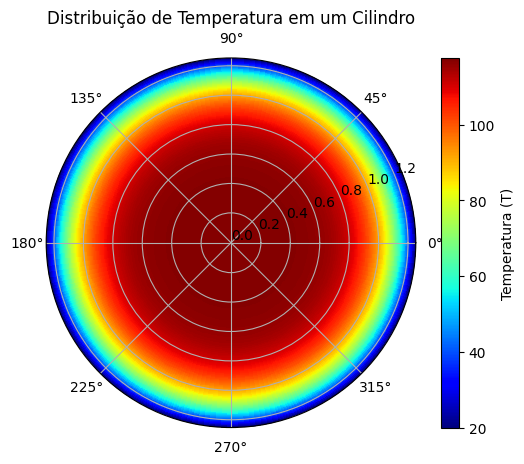

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm

# Configurações da simulação
T0 = 20    # Temperatura inicial
S = 1000     # Taxa de geração interna de calor
R = 1      # Raio do fio
K = 0.5    # Coeficiente de condução térmica
alfa = 4   # Difusividade térmica
num_points = 200                    # Número de pontos no diâmetro do fio
dr = R / (num_points)               # Passo de raio
dt = 0.5 * (dr**2) /(4 * alfa)      # Passo de tempo
beta = alfa * dt / (dr**2)          # Parâmetro beta
tempo = 10000 * dt
nsteps = int(tempo / dt)

# Inicialização do array de temperatura
u = T0 * np.ones(num_points)

# Gerar dados
theta = np.linspace(0, 2 * np.pi, num_points)
r = np.linspace(0, R, num_points)

# Criar um grid polar
r, theta = np.meshgrid(r, theta)

# Cria um tensor de shape = (num_points,num_points,nsteps) para armazenar
# todas as informações da simulação
T = np.tile(u,(num_points,1))
T_tensor =T.copy().reshape((num_points,num_points,1))

tempo_array = np.linspace(0, tempo, nsteps-1)
tempo_tensor = tempo_array.copy().reshape((1,1,nsteps-1))

tempo_tensor_broadcasted = np.broadcast_to(tempo_tensor, (T_tensor.shape[0], T_tensor.shape[1], tempo_tensor.shape[2]))

mapa_temporal = np.concatenate((T_tensor, tempo_tensor_broadcasted), axis=-1)
print(mapa_temporal.shape)

# Simulação
for k in range(len(tempo_array)):
  u0 = u.copy()

  u[0] = (1 - 4*beta) * u0[0] + 4*beta * u0[1] + ((alfa * dt)/K) * S
  for i in range(1, num_points -1):
    u[i] = (beta - beta/(2*i)) * u0[i-1] + (1 - 2*beta) * u0[i] + (beta + beta/(2*i)) * u0[i+1] + ((alfa * dt)/K) * S

    #T = np.tile(u,(num_points,1))
    mapa_temporal[:, :, k] = np.tile(u, (num_points, 1))
    #mapa_temporal[i,:,k] = u[i]

  #print(f"Temperatura média: {np.average(u)}ºC")

# Seleciona os frames a serem animados
movie_frames = mapa_temporal[:,:,0::50]   #200 frames animados

# Visualização
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
pcm = ax.pcolormesh(theta,r, movie_frames[:,:,0], cmap ='jet', vmin = T0, vmax = np.max(u))
plt.colorbar(pcm, ax=ax, label='Temperatura (T)')
ax.set_title('Distribuição de Temperatura em um Cilindro')
#pcm = ax.pcolormesh(T, cmap=plt.cm.jet, vmin=20, vmax=80)

#Define the initialization function for the animation.  In this case, the function returns the first frame
#of the movie animation.
def init():
    pcm.set_array(movie_frames[:,:,0].ravel())
    return pcm,

#Define the animation update function.  In this function, each map image will be updated with the current frame.
def animate(i):
    pcm.set_array(movie_frames[:,:,i].ravel())
    return pcm,

# 200 frames = 10 s * x frames por segundo
# x = 20 frames por segundo // intervalo = 50 ms

#Call the full animation function.  The number of frames is given by the last element of the shape tuple of
#of the movie frames array.  The time interval between each frame is 50 ms, which will show the animated movie
#at 20 fps
anim = animation.FuncAnimation(fig, animate, init_func = init, frames = movie_frames.shape[2], interval = 50)

#Save the animation as an avi movie file.
anim.save('heatmap_animation.gif')

#Display the resulting animated heat map, which shows temperature changes in the plate over time as it cools down.
plt.show()

In [ ]:
u

array([81.86935094, 81.86934286, 81.8693186 , 81.86927804, 81.86922098,
       81.86914716, 81.86905621, 81.86894771, 81.86882114, 81.86867589,
       81.86851129, 81.86832655, 81.8681208 , 81.86789308, 81.86764231,
       81.86736733, 81.86706685, 81.86673948, 81.86638371, 81.8659979 ,
       81.86558028, 81.86512896, 81.86464188, 81.86411684, 81.86355148,
       81.86294328, 81.86228954, 81.86158736, 81.86083367, 81.86002516,
       81.85915834, 81.85822946, 81.85723454, 81.85616935, 81.85502939,
       81.85380986, 81.85250569, 81.85111147, 81.84962147, 81.84802961,
       81.84632945, 81.84451416, 81.84257649, 81.84050879, 81.83830294,
       81.83595035, 81.83344194, 81.83076811, 81.8279187 , 81.82488299,
       81.82164966, 81.81820674, 81.81454161, 81.81064096, 81.80649073,
       81.80207613, 81.79738155, 81.79239056, 81.78708583, 81.78144914,
       81.77546132, 81.76910219, 81.76235054, 81.75518405, 81.7475793 ,
       81.73951167, 81.7309553 , 81.72188306, 81.71226648, 81.70

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm

# Configurações da simulação
T0 = 20    # Temperatura inicial
S = 1000     # Taxa de geração interna de calor
R = 1      # Raio do fio
K = 0.5    # Coeficiente de condução térmica
alfa = 4*10   # Difusividade térmica
num_points = 200                    # Número de pontos no diâmetro do fio
dr = R / (num_points)               # Passo de raio
dt = 0.5 * (dr**2) /(4 * alfa)      # Passo de tempo
beta = alfa * dt / (dr**2)          # Parâmetro beta
tempo = 10000 * dt
nsteps = int(tempo / dt)

# Inicialização do array de temperatura
u = T0 * np.ones(num_points)

# Gerar dados
theta = np.linspace(0, 2 * np.pi, num_points)
r = np.linspace(0, R, num_points)

# Criar um grid polar
r, theta = np.meshgrid(r, theta)

# Cria um tensor de shape = (num_points,num_points,nsteps) para armazenar
# todas as informações da simulação
T = np.tile(u,(num_points,1))
T_tensor =T.copy().reshape((num_points,num_points,1))

tempo_array = np.linspace(0, tempo, nsteps-1)
tempo_tensor = tempo_array.copy().reshape((1,1,nsteps-1))

tempo_tensor_broadcasted = np.broadcast_to(tempo_tensor, (T_tensor.shape[0], T_tensor.shape[1], tempo_tensor.shape[2]))

mapa_temporal = np.concatenate((T_tensor, tempo_tensor_broadcasted), axis=-1)
print(mapa_temporal.shape)

# Simulação
for k in range(len(tempo_array)):
  u0 = u.copy()

  u[0] = (1 - 4*beta) * u0[0] + 4*beta * u0[1] + ((alfa * dt)/K) * S
  for i in range(1, num_points -1):
    if i != (num_points - 2):
      u[i] = (beta - beta/(2*i)) * u0[i-1] + (1 - 2*beta) * u0[i] + (beta + beta/(2*i)) * u0[i+1] + ((alfa * dt)/K) * S
    else:
      u[i] = (beta - beta/(2*i)) * u0[i-1] + (1 - 2*beta) * u0[i] + (beta + beta/(2*i)) * u0[i-1] + ((alfa * dt)/K) * S
    #print(u)

    # u[0] = 100

    #T = np.tile(u,(num_points,1))
    mapa_temporal[:, :, k] = np.tile(u, (num_points, 1))
    #mapa_temporal[i,:,k] = u[i]

  #print(f"Temperatura média: {np.average(u)}ºC")

# Seleciona os frames a serem animados
movie_frames = mapa_temporal[:,:,0::50]   #200 frames animados

# Visualização
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
pcm = ax.pcolormesh(theta,r, movie_frames[:,:,0], cmap ='jet', vmin = T0, vmax = np.max(u))
plt.colorbar(pcm, ax=ax, label='Temperatura (T)')
ax.set_title('Distribuição de Temperatura em um Cilindro')
#pcm = ax.pcolormesh(T, cmap=plt.cm.jet, vmin=20, vmax=80)

#Define the initialization function for the animation.  In this case, the function returns the first frame
#of the movie animation.
def init():
    pcm.set_array(movie_frames[:,:,0].ravel())
    return pcm,

#Define the animation update function.  In this function, each map image will be updated with the current frame.
def animate(i):
    pcm.set_array(movie_frames[:,:,i].ravel())
    return pcm,

# 200 frames = 10 s * x frames por segundo
# x = 20 frames por segundo // intervalo = 50 ms

#Call the full animation function.  The number of frames is given by the last element of the shape tuple of
#of the movie frames array.  The time interval between each frame is 50 ms, which will show the animated movie
#at 20 fps
anim = animation.FuncAnimation(fig, animate, init_func = init, frames = movie_frames.shape[2], interval = 50)

#Save the animation as an avi movie file.
anim.save('heatmap_animation.gif')

#Display the resulting animated heat map, which shows temperature changes in the plate over time as it cools down.
plt.show()